In [54]:
# импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [59]:

# загрузим тренировочный и тестовый датасеты
train_df = pd.read_parquet('train_df.pq')
test_df = pd.read_parquet('test_df.pq')



In [5]:
# выведем на экран первые 5 строк тренировочного датасета
train_df.head(5).transpose()

,594381,572589,572590,572591,572592
query_id,pvbPOaSGDySzWPes,jwAzLAO34WtI9mQP,jwAzLAO34WtI9mQP,jwAzLAO34WtI9mQP,jwAzLAO34WtI9mQP
item_id,dd6a4af0dacd0cb9e1e7c4838ba442231b1eac8ad0d6a7...,6da258cefe0b4150f942a7ff47daab5eb658f5590e72a2...,6da258cefe0b4150f942a7ff47daab5eb658f5590e72a2...,6da258cefe0b4150f942a7ff47daab5eb658f5590e72a2...,6da258cefe0b4150f942a7ff47daab5eb658f5590e72a2...
seller_id,ed9525751c7e70df9af1b6e5bf0b8bf807de3645e14ae0...,0906a845ab40b7f965fa2c27dfc457cb138d5d24af7bde...,0906a845ab40b7f965fa2c27dfc457cb138d5d24af7bde...,0906a845ab40b7f965fa2c27dfc457cb138d5d24af7bde...,0906a845ab40b7f965fa2c27dfc457cb138d5d24af7bde...
query_text,пвз озон,продавец консультант одежды,продавец консультант одежды,продавец консультант одежды,продавец консультант одежды
serp_query_cat,111,111,111,111,111
query_mcat,61.0,61.0,61.0,61.0,61.0
serp_query_loc,661420,641780,641780,641780,641780
item_cat_id,111,111,111,111,111
item_mcat_id,2278181,2278189,2278189,2278189,2278189
item_loc,661420,641780,641780,641780,641780


**EDA - Exploratory Data Analysis**

Баланс классов:item_contact
0.0    2134482
1.0     143015
Name: count, dtype: int64
Доля совершивших контакт 6.28%


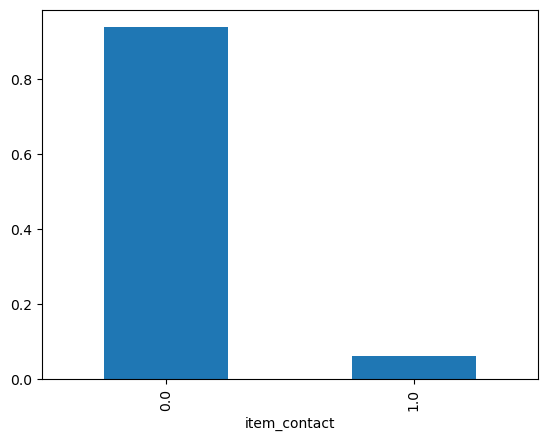

In [60]:
# 1. рассмотрим целевой признак
train_df['item_contact'].value_counts(normalize=True).plot(kind='bar')
print(f'Баланс классов:{train_df['item_contact'].value_counts()}')
print(f'Доля совершивших контакт {train_df['item_contact'].mean():.2%}')

Наблюдаем сильный дизбаланс классов, свойственный таким задачам

In [61]:
# 2. рассмотрим дубликаты
duplicates = train_df[train_df.duplicated()]
unique_duplicates = train_df.drop_duplicates()
print(f'Количество уникальных строк после удаления дубликатов - {len(unique_duplicates)}')
print(f'Доля дубликатов от всего тренировочного датасета {len(duplicates) / len(train_df)}')

# гипотеза 1 влияют ли дубликаты на значение целевого признака?

duplicates_contact_rate = duplicates['item_contact'].mean()
unique_contact_rate = unique_duplicates['item_contact'].mean()
print(f'Доля совершивших контакт среди дубликатов: {duplicates_contact_rate:.2%}')
print(f'Доля совершивших контакт среди уникальных значений: {unique_contact_rate:.2%}')

Количество уникальных строк после удаления дубликатов - 1778207
Доля дубликатов от всего тренировочного датасета 0.21922751160594284
Доля совершивших контакт среди дубликатов: 2.80%
Доля совершивших контакт среди уникальных значений: 7.26%


Можно увидеть, что почти 22% датасета это дубликаты, а конверсия в дубликатах сильно ниже конверсии в уникальных записях.
Важно понять, являются ли дубликаты информативными или их нужно удалить.

In [63]:
# проверим совпадение query_id(id сессии) и item_id(id вакансии)
duplicate_groups = train_df[train_df.duplicated(subset=['query_id', 'item_id'])]
print(f'Совпадение query_id+item_id: {len(duplicate_groups)}')

# проверим полное совпадение в других столбцах
subset_columns = ['query_id', 'item_id', 'seller_id', 'serp_query_loc', 'item_loc']
exact_duplicates = train_df[train_df.duplicated(subset=subset_columns)]
print(f'Полное совпадение всех ключевых полей: {len(exact_duplicates)}')

# проверим время между дубликатами
duplicates_time_diff = duplicate_groups.groupby(['query_id', 'item_id'])['event_date'].apply(
    lambda x: (x.max() - x.min()).total_seconds() / 3600)
print(f'Средняя разница во времени между дубликатами: {duplicates_time_diff.mean():.2f} часов')

Совпадение query_id+item_id: 502593
Полное совпадение всех ключевых полей: 502593
Средняя разница во времени между дубликатами: 0.00 часов


Выводы - совпадение неинформативны и скорее всего, являются ошибкой, удалим дубликаты

In [64]:
train_df_clean = train_df.drop_duplicates()

In [65]:
# проверим наличие NaN значений в датасете
nan_count = train_df_clean.isna().sum()
nan_percentage = (nan_count / len(train_df_clean)) ** 100

nan_data = pd.DataFrame({
    'Количество пропусков':nan_count,
    'Доля пропусков': nan_percentage
})
print(nan_data[nan_data['Количество пропусков'] > 0])

            Количество пропусков  Доля пропусков
query_mcat                160450   3.433528e-105


Пропущенные значения есть только в поле query_mcat(категория профессии), гипотеза - query_mcat это подкатегория профессии запроса и пропущенные значения появляются когда подкатегория отсутствует


In [66]:
# проверим конверсию с наличием/отсутствием значения query_mcat
conversion_query_mcat = train_df_clean[train_df_clean['query_mcat'].notna()]['item_contact'].mean()
conversion_noquery_mcat = train_df_clean[train_df_clean['query_mcat'].isna()]['item_contact'].mean()
print(f'Конверсия когда query_mcat есть: {conversion_query_mcat:.2%}')
print(f'Конверсия когда query_mcat пропущена: {conversion_noquery_mcat:.2%}')
# гипотеза оказалась верной, обработаем значения NaN
train_df_clean['query_mcat'] = train_df_clean['query_mcat'].fillna('no_subcategory')
test_df['query_mcat'] = test_df['query_mcat'].fillna('no_subcategory')

Конверсия когда query_mcat есть: 7.18%
Конверсия когда query_mcat пропущена: 7.99%


C:\Users\scyth\AppData\Local\Temp\ipykernel_1324\4216324647.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_clean['query_mcat'] = train_df_clean['query_mcat'].fillna('no_subcategory')


Проведем анализ взаимосвязей

<Axes: >

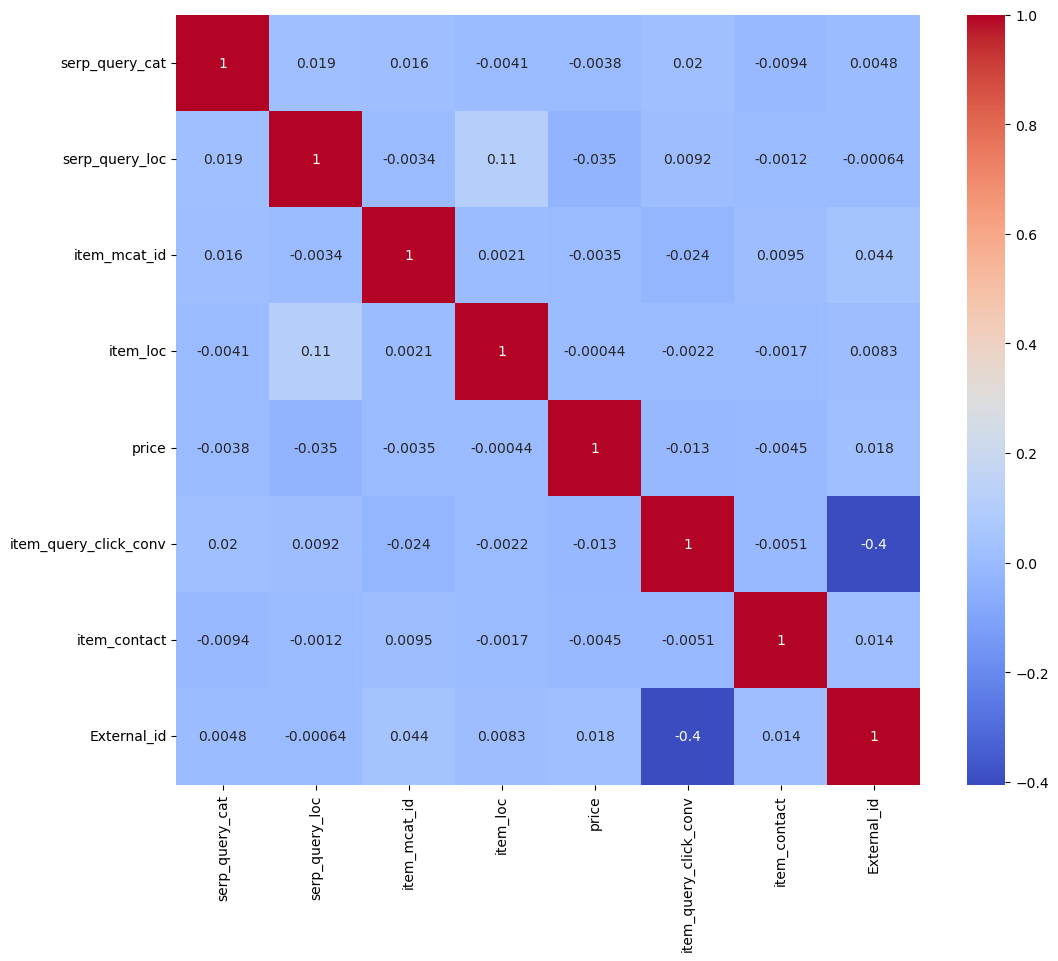

In [75]:
# составим список столбцов с int значениями, пропустив query_mcat
numeric_cols = ['serp_query_cat', 'serp_query_loc', 'item_mcat_id', 'item_loc', 'price', 'item_query_click_conv', 'item_contact', 'External_id']
correlation_matrix = train_df_clean[numeric_cols].corr()

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

In [ ]:
# импортируем библиотеки для обучения модели, метрики roc-auc и train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from
features = train_df_clean.drop['item_contact']
target = train_df_clean['item_contact']

features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=1
)
